In [1]:
import fastai
import math
import os
import pprint
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

from datetime import (
    datetime
)

from sklearn.preprocessing import (
    StandardScaler
)

from fastai.tabular.all import (
    LinBnDrop
)

from fastai.layers import (
    Identity

)

from typing import (
    Callable,
    Dict,
    List,
    Tuple
)

from Quick.cleaning.loading import (
    examine_dataset,
    remove_infs_and_nans
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from rff.layers import (
    GaussianEncoding,
)

from Quick.constants import *

pretty = pprint.PrettyPrinter(indent=4).pprint

from fastai.metrics import (
    BalancedAccuracy,
    F1Score,
    MatthewsCorrCoef,
    Precision,
    Recall,
    RocAuc
)

METRICS: list = [
    accuracy, 
    BalancedAccuracy(), 
    # RocAuc(), 
    MatthewsCorrCoef(), 
    F1Score(average='macro'), 
    Precision(average='macro'), 
    Recall(average='macro')
]

In [2]:
use_gpu: bool = False

if(use_gpu):

    if(torch.backends.mps.is_available()): # For Mac M1/M2 chips
        device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    else: # For NVIDIA cuda chips
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
    device = torch.device('cpu')

print(f'We are currently using the device: {device}')

We are currently using the device: cpu


In [3]:
data_path_1: str = r'C:\Users\smbm2\projects\TrafficFlowForecasting\warins_experiments\data\CSV\Scenario-B'
data_sets_1: list = [
    'TimeBasedFeatures-10s-Layer2.csv'
]

file_path_1: callable = get_file_path(data_path_1)
file_set_1: list = list(map(file_path_1, data_sets_1))

print(f'The datasets we will be working with are:')
pretty(file_set_1)

The datasets we will be working with are:
[   'C:\\Users\\smbm2\\projects\\TrafficFlowForecasting\\warins_experiments\\data\\CSV\\Scenario-B\\TimeBasedFeatures-10s-Layer2.csv']


In [4]:
dataset_1 = examine_dataset(0, file_set_1, data_sets_1)

Dataset 0/1: We now look at C:\Users\smbm2\projects\TrafficFlowForecasting\warins_experiments\data\CSV\Scenario-B\TimeBasedFeatures-10s-Layer2.csv


Loading Dataset: C:\Users\smbm2\projects\TrafficFlowForecasting\warins_experiments\data\CSV\Scenario-B\TimeBasedFeatures-10s-Layer2.csv
	To Dataset Cache: ./cache/TimeBasedFeatures-10s-Layer2.csv.pickle


        File:				C:\Users\smbm2\projects\TrafficFlowForecasting\warins_experiments\data\CSV\Scenario-B\TimeBasedFeatures-10s-Layer2.csv  
        Job Number:			0
        Shape:				(8044, 29)
        Samples:			8044 
        Features:			29
    


In [5]:
# we are going to select a random subset of our data

df = dataset_1['Dataset'].sample(frac=1, random_state=42) #using all of it

In [6]:
dataset_1['Dataset'].shape

(8044, 29)

In [7]:
df.shape

(8044, 29)

In [8]:
df.columns

Index(['Source IP', ' Source Port', ' Destination IP', ' Destination Port',
       ' Protocol', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min',
       'Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
       'Active Mean', ' Active Std', ' Active Max', ' Active Min', 'Idle Mean',
       ' Idle Std', ' Idle Max', ' Idle Min', 'label'],
      dtype='object')

In [ ]:
df['label'].value_counts()

In [9]:
#renaming the application type and traffic type
df.rename(columns={'label': 'Traffic Type'}, inplace=True)
df.columns

Index(['Source IP', ' Source Port', ' Destination IP', ' Destination Port',
       ' Protocol', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min',
       'Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
       'Active Mean', ' Active Std', ' Active Max', ' Active Min', 'Idle Mean',
       ' Idle Std', ' Idle Max', ' Idle Min', 'Traffic Type'],
      dtype='object')

In [ ]:
df.head()

In [10]:
active_columns = [
    'Active Mean', 
    ' Active Std', 
    ' Active Max', 
    ' Active Min',
]
flow_iat_columns = [
    ' Flow IAT Mean', 
    ' Flow IAT Std', 
    ' Flow IAT Max', 
    ' Flow IAT Min'
]

flow_columns = [
    ' Flow Duration', 
    ' Flow Bytes/s', 
    ' Flow Packets/s'
]
fwd_iat_columns = [
    'Fwd IAT Mean', 
    ' Fwd IAT Std', 
    ' Fwd IAT Max', 
    ' Fwd IAT Min',
]

bwd_iat_columns = [
    'Bwd IAT Mean', 
    ' Bwd IAT Std', 
    ' Bwd IAT Max', 
    ' Bwd IAT Min'
]

idle_columns = [
    'Idle Mean', 
    ' Idle Std',
    ' Idle Max', 
    ' Idle Min', 
]


label_columns = [
    'Traffic Type', 
]

feature_groups = {
    'flow_iat': flow_iat_columns,
    'flow': flow_columns,
    'fwd_iat': fwd_iat_columns,
    'bwd_iat': bwd_iat_columns,
    'active': active_columns,
    'idle': idle_columns
}

features = []

for group in feature_groups.values():
    features.extend(group)

columns = features + label_columns

# we reorder the columns
df = df[columns]

In [ ]:
df.head()

Shape of Input Data: (8044, 24)


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.434161,1.809029,0.325871,0.313461,0.803603,0.260122,0.232280,0.228633,0.313461,00:01
1,1.098282,1.278340,0.543532,0.413187,0.861680,0.469646,0.377953,0.511531,0.413187,00:01
2,0.994843,2.466569,0.365672,0.335176,0.793658,0.300578,0.261305,0.379865,0.335176,00:01
3,0.940584,1.043795,0.688433,0.487967,0.886836,0.622133,0.471786,0.490021,0.487967,00:01
4,0.897679,1.285660,0.582711,0.412934,0.869992,0.498875,0.382923,0.438320,0.412934,00:01
5,0.840683,1.848813,0.304726,0.267956,0.820480,0.196339,0.219687,0.329130,0.267956,00:01
6,0.808951,1.908272,0.301617,0.296827,0.834771,0.244042,0.230342,0.360935,0.296827,00:01
7,0.763612,1.371154,0.546020,0.397431,0.890501,0.478431,0.350782,0.618315,0.397431,00:01
8,0.745251,1.474593,0.376244,0.329175,0.877145,0.313165,0.299661,0.661605,0.329175,00:01
9,0.715864,2.143835,0.322139,0.311729,0.822498,0.275233,0.252397,0.437788,0.311729,00:01


c:\Users\smbm2\miniconda3\envs\trafficTransformer\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


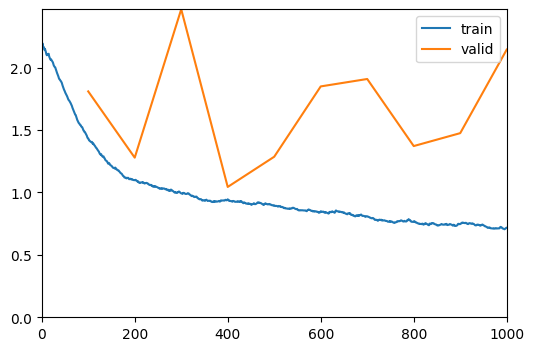

c:\Users\smbm2\miniconda3\envs\trafficTransformer\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\smbm2\miniconda3\envs\trafficTransformer\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\smbm2\miniconda3\envs\trafficTransformer\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\smbm2\mini

loss: 2.1438350677490234, accuracy:  32.21%


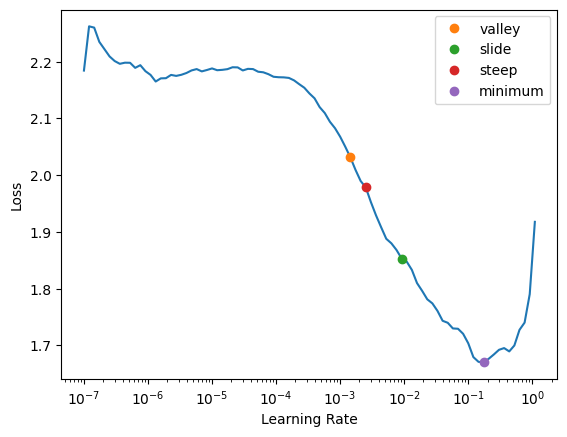

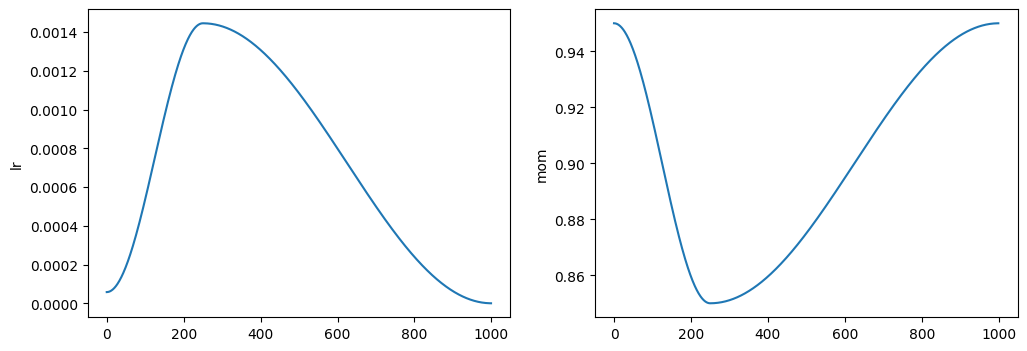

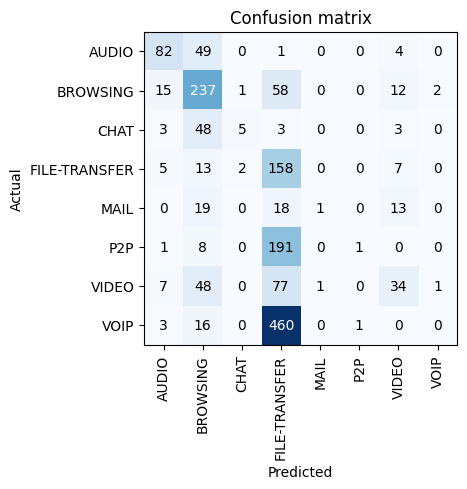

In [11]:
results_dnn = run_deep_nn_experiment(
    df, 
    dataset_1['File'],                 # stuff for logging
    'Traffic Type',                # the column we are trying to predict
    (100 for _ in range(10))           # we use 10 layers with 100 neurons each
)

Shape of Input Data: (8044, 24)
Layer sizes: [23, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 8], length: 12
Number of residual blocks: 9
Residual locations:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.903844,1.542136,0.531716,0.350715,0.771384,0.416471,0.342682,0.381091,0.350715,00:01
1,1.294069,1.264172,0.585821,0.402264,0.854452,0.486162,0.392108,0.403087,0.402264,00:01
2,1.117483,1.240970,0.593284,0.413622,0.866659,0.496619,0.404779,0.429632,0.413622,00:01
3,1.024349,1.216706,0.603234,0.427345,0.858792,0.509981,0.419587,0.438084,0.427345,00:01
4,0.981078,1.136884,0.629353,0.456880,0.878068,0.541788,0.461593,0.497311,0.456880,00:01
5,0.958475,1.068944,0.644279,0.462011,0.887102,0.562147,0.451539,0.483978,0.462011,00:01
6,0.904764,1.120558,0.627488,0.453711,0.882755,0.541499,0.446951,0.526952,0.453711,00:01
7,0.908243,1.046319,0.648010,0.465300,0.891979,0.566111,0.456593,0.482175,0.465300,00:01
8,0.878914,1.048306,0.654851,0.477119,0.890631,0.574677,0.475024,0.509762,0.477119,00:01
9,0.866627,1.038128,0.654851,0.471199,0.892353,0.574954,0.467783,0.497686,0.471199,00:01


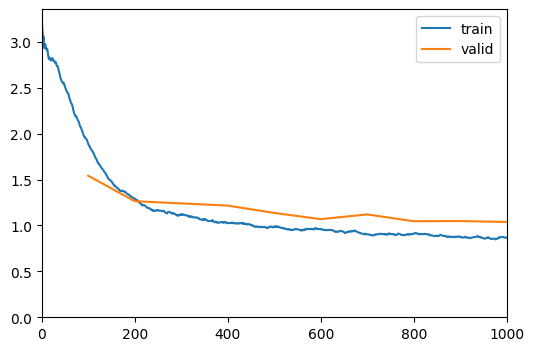

c:\Users\smbm2\miniconda3\envs\trafficTransformer\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 1.0381275415420532, accuracy:  65.49%


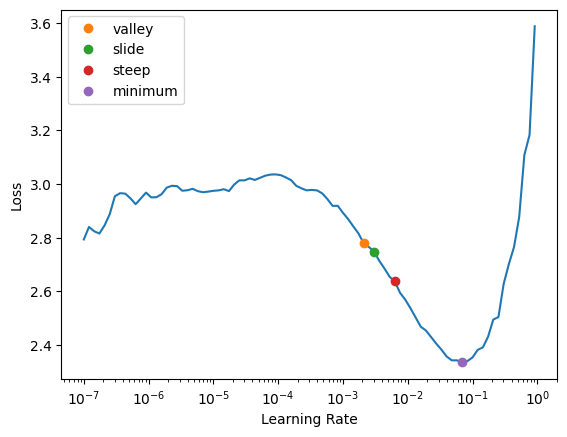

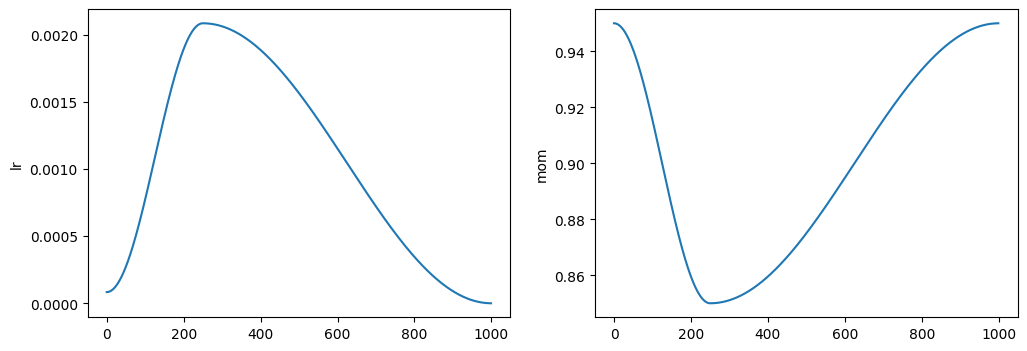

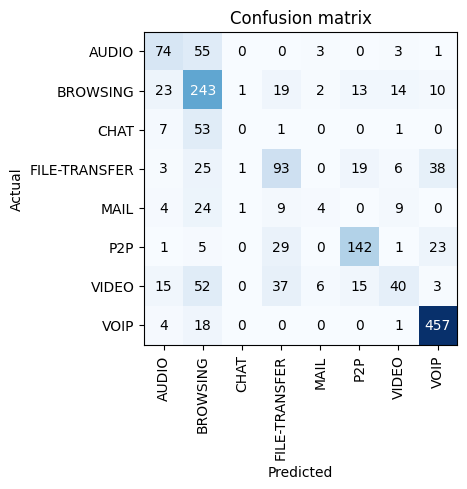

In [23]:
results_res_type_1 = run_residual_deep_nn_experiment(
    df, 
    dataset_1['File'], 
    'Traffic Type', 
    (100 for _ in range(10))
)

In [21]:
# results_sk = run_sk_experiment(
#     df, 
#     dataset_1['File'], 
#     'Traffic Type'
# )

#does not work. Will do it from scratch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=['Traffic Type'])
y = df['Traffic Type']

le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Convert DataFrame to NumPy arrays and make them C-contiguous
X_train = np.ascontiguousarray(X_train.values)
X_test = np.ascontiguousarray(X_test.values)
y_train = np.ascontiguousarray(y_train)
y_test = np.ascontiguousarray(y_test)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

pred = knn_model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(confusion_matrix(y_test, pred))
print(acc)
print("precision: ", precision_score(y_test, pred, average='weighted'))

[[ 92  38   2   0   2   1   8   1]
 [ 33 222  10  12   7  14  26   4]
 [  1  34  10   0   0   2   1   4]
 [  0  13   0 123   3   3  22   0]
 [  6  24   6   6  14   1  16   1]
 [  3   9   1   1   0 218   4   0]
 [ 19  41   1  23   5   4  57   0]
 [  5   9   1   3   1   1   4 437]]
0.7290242386575513
precision:  0.7226506219980531


In [22]:
class BottleneckResidualBlock(nn.ModuleList):
# class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        super().__init__(branches)
        
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        if(in_size != out_size):
            self.identity_path = LinBnDrop(in_size, out_size)
        else:
            self.identity_path = Identity()


    def forward(self, inputs):

        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.identity_path(inputs)
        return fx + inputs



class Simple_Resnet_Model(nn.Module):
    def __init__(self, input_features=62, layers=[100 for _ in range(10)], output_features=8, config: dict = None, device: str = 'cpu'):
        super().__init__()
        self._layers = []
        _activations = [nn.ReLU(inplace=True) for _ in range(len(layers) - 1)] + [None]

        for i, x in enumerate(layers):
            print(i)
            if (i == 0):
                self._layers.append(BottleneckResidualBlock([LinBnDrop(input_features, layers[i+1], act=_activations[i], lin_first=True)], i, input_features, layers[i+1]))
            elif (i == len(layers) - 1):
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, output_features, act=_activations[i], lin_first=True)], i, x, output_features))
                # self._layers.append(LinBnDrop(x, output_features, act=_activations[i], lin_first=True))
            else:
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, layers[i+1], act=_activations[i], lin_first=True)], i, x, layers[i+1]))
        
        self.out = nn.Sequential(*self._layers)     
        
    def forward(self, x):
        return self.out(x)



Shape of Input Data: (8044, 24)
0
1
2
3
4
5
6
7
8
9


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.281603,1.572854,0.301617,0.301240,0.822678,0.212981,0.264424,0.298328,0.301240,00:01
1,1.033322,1.182353,0.618159,0.434361,0.873955,0.536133,0.417507,0.482982,0.434361,00:01
2,0.945816,1.467816,0.501244,0.314326,0.849824,0.412643,0.275916,0.372762,0.314326,00:01
3,0.898220,1.176660,0.584577,0.390442,0.892921,0.503502,0.349501,0.504980,0.390442,00:01
4,0.840292,1.058686,0.633085,0.443554,0.895618,0.548002,0.439745,0.486719,0.443554,00:01
5,0.794268,1.895440,0.364428,0.345991,0.861051,0.285254,0.289276,0.305977,0.345991,00:01
6,0.747995,1.132400,0.570895,0.394193,0.900521,0.504369,0.397761,0.494801,0.394193,00:01
7,0.723764,1.666306,0.336443,0.326836,0.868739,0.253069,0.259006,0.387957,0.326836,00:01
8,0.689875,1.186291,0.547886,0.425724,0.903593,0.476685,0.391018,0.555102,0.425724,00:01
9,0.665115,1.334757,0.446517,0.379684,0.894490,0.375053,0.326968,0.472823,0.379684,00:01


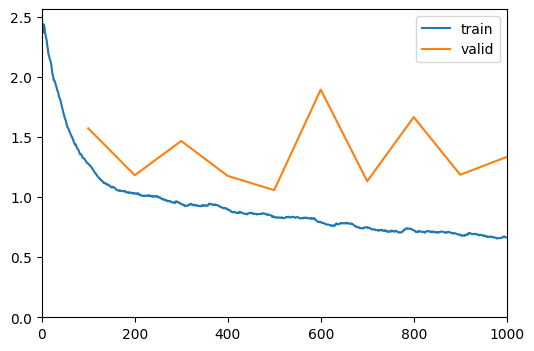

c:\Users\smbm2\miniconda3\envs\trafficTransformer\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\smbm2\miniconda3\envs\trafficTransformer\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\smbm2\miniconda3\envs\trafficTransformer\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\smbm2\mini

loss: 1.334756851196289, accuracy:  44.65%


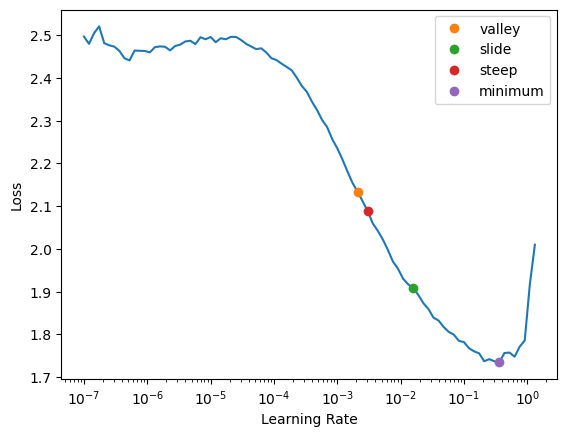

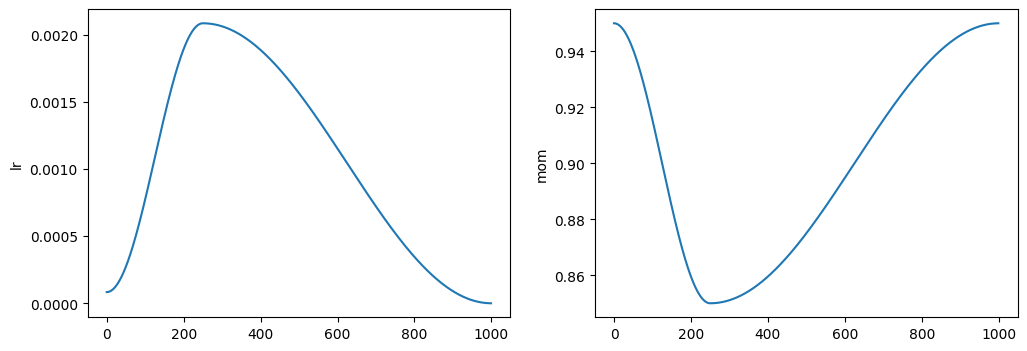

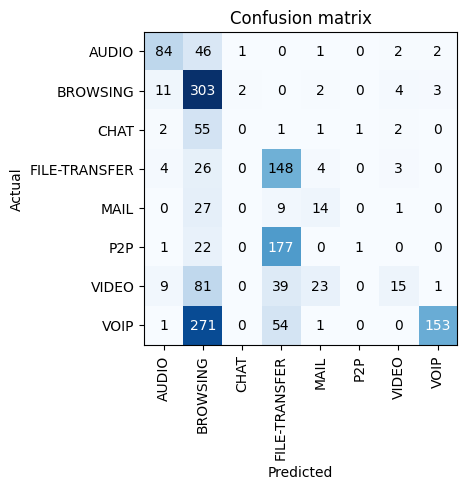

In [24]:
results_res_type_2 = run_torch_nn_experiment(
    df, 
    dataset_1['File'], 
    'Traffic Type', 
    Simple_Resnet_Model
)

In [25]:
model_1 = results_dnn.model.model.model
model_2 = results_res_type_1.model.model.model
model_3 = results_res_type_2.model.model.model

results_1 = results_dnn.model.model.validate()
results_2 = results_res_type_1.model.model.validate()
results_3 = results_res_type_2.model.model.validate()

print(f"Deep NN 100x10: \t\t\t{sum(p.numel() for p in model_1.parameters() if p.requires_grad)} parameters, {results_1[1]*100} accuracy")
print(f"Deep Res NN 100x10: \t\t\t{sum(p.numel() for p in model_2.parameters() if p.requires_grad)} parameters, {results_2[1]*100} accuracy")
print(f"Simple Res NN 100x10: \t\t{sum(p.numel() for p in model_3.parameters() if p.requires_grad)} parameters, {results_3[1]*100} accuracy")

Deep NN 100x10: 			95154 parameters, 32.213929295539856 accuracy
Deep Res NN 100x10: 			95154 parameters, 65.4850721359253 accuracy
Simple Res NN 100x10: 		88308 parameters, 44.65174078941345 accuracy


In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
assert False, f"Nothing after this point is included in the study. Time: {timestamp}"